# Summer School on Data Science Tools and Techniques in Modelling Complex Networks

### [Bogumił Kamiński](http://bogumilkaminski.pl/about/)

## Working with graph data using Julia Language
### Day 2, Tuesday, August 20th, 2019, 13:00 to 16:00

## Random Geometric Graph

In [1]:
using Pkg
Pkg.activate(".");

In [2]:
using LightGraphs, GraphPlot, Random, PyPlot, Statistics

In [3]:
struct RandomGeometricGraph{T<:SimpleGraph}
    g::T
    r::Float64
    l::Vector{Tuple{Float64,Float64}}
end

squared distance between $(x_1, y_1)$ and $(x_2, y_2)$.

In [4]:
euclidean(x₁, y₁, x₂, y₂) = sqrt((x₁-x₂)^2 + (y₁-y₂)^2)

euclidean (generic function with 1 method)

In [5]:
function rgg_slow(n, r)
    g = SimpleGraph(n)
    l = [(rand(), rand()) for i in 1:n]
    for i in 1:n, j in i+1:n
        euclidean(l[i]..., l[j]...) < r && add_edge!(g, i, j)
    end
    RandomGeometricGraph(g, r, l)
end

rgg_slow (generic function with 1 method)

In [6]:
g = rgg_slow(200, 0.1)

RandomGeometricGraph{SimpleGraph{Int64}}({200, 611} undirected simple Int64 graph, 0.1, Tuple{Float64,Float64}[(0.750136, 0.272617), (0.197693, 0.314618), (0.0136714, 0.854771), (0.347588, 0.39332), (0.633658, 0.504953), (0.231469, 0.340342), (0.208086, 0.534281), (0.0906406, 0.296507), (0.879073, 0.74515), (0.932851, 0.519877)  …  (0.454232, 0.313565), (0.772961, 0.599298), (0.602331, 0.830577), (0.172772, 0.23677), (0.619658, 0.855684), (0.0825175, 0.477826), (0.875213, 0.665766), (0.431099, 0.323682), (0.227866, 0.40029), (0.162503, 0.50464)])

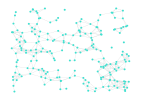

In [7]:
gplot(g.g, getindex.(g.l, 1), getindex.(g.l, 2))

In [8]:
function rgg_fast(n, r)
    g = SimpleGraph(n)
    l = [(rand(), rand()) for i in 1:n]
    k = ceil(Int, 1 / r)
    vgroups = [Int[] for i in 1:k, j in 1:k]
    for (i, loc) in enumerate(l)
        x, y = floor.(Int, loc ./ k) .+ 1
        push!(vgroups[x,y], i)
    end
    for x in 1:k, y in 1:k
        vgroup = vgroups[x, y]
        # within group links
        for a in 1:length(vgroup)
            i = vgroup[a]
            for b in i+1:1:length(vgroup)
                j = vgroup[b]
                euclidean(l[i]..., l[j]...) < r && add_edge!(g, i, j)
            end
        end
        # between group links
        if isodd(x+y)
            for (dx, dy) in ((-1, 0), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1))
                if 0 < dx < k && 0 < dy < k
                    for i in vgroup
                        for j in vgroups[x+dx, y+dy]
                            euclidean(l[i]..., l[j]...) < r && add_edge!(g, i, j)
                        end
                    end
                end
            end
        end
    end
    RandomGeometricGraph(g, r, l)
end

rgg_fast (generic function with 1 method)

In [9]:
g = rgg_fast(200, 0.1)

RandomGeometricGraph{SimpleGraph{Int64}}({200, 550} undirected simple Int64 graph, 0.1, Tuple{Float64,Float64}[(0.484822, 0.766701), (0.366263, 0.242747), (0.843735, 0.49344), (0.725947, 0.867517), (0.511828, 0.456621), (0.536382, 0.163196), (0.0754482, 0.475078), (0.645857, 0.614421), (0.758618, 0.800299), (0.681633, 0.884137)  …  (0.594839, 0.200936), (0.622087, 0.203425), (0.726394, 0.46943), (0.875004, 0.979872), (0.638713, 0.273188), (0.407146, 0.795979), (0.0651071, 0.130359), (0.0529704, 0.968106), (0.434334, 0.919168), (0.492784, 0.746347)])

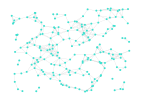

In [10]:
gplot(g.g, getindex.(g.l, 1), getindex.(g.l, 2))

In [11]:
function test_gen(nrange, rrange)
    seeds = rand(UInt64, length(nrange)*length(rrange))
    for (s, (n, r)) in zip(seeds, Iterators.product(nrange, rrange))
        Random.seed!(s)
        g1 = rgg_slow(n, r)
        Random.seed!(s)
        g2 = rgg_fast(n, r)
        @assert g1.g == g2.g && g1.l == g2.l && g1.r == g2.r
    end
    println("All OK")
end

test_gen (generic function with 1 method)

In [12]:
test_gen(rand(10:1000, 10), rand(10))

All OK


## Mean degree

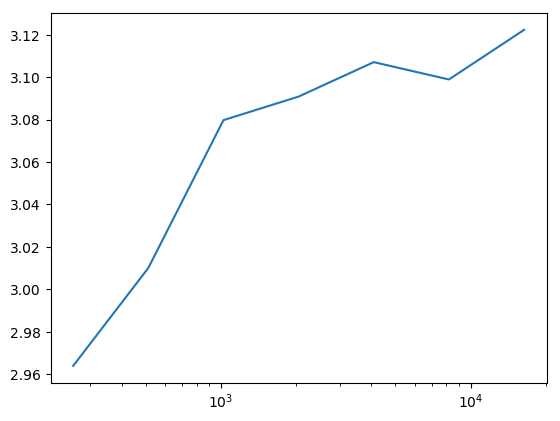

In [13]:
ns = [2^i for i in 8:14]
plot(ns, [mean(mean(degree(rgg_fast(n, 1/sqrt(n)).g)) for i in 1:16) for n in ns])
plt.xscale("log")

## Giant component

In [14]:
giant_component(n, r) =
    maximum(length.(connected_components(rgg_fast(n, r).g))) / n

giant_component (generic function with 1 method)

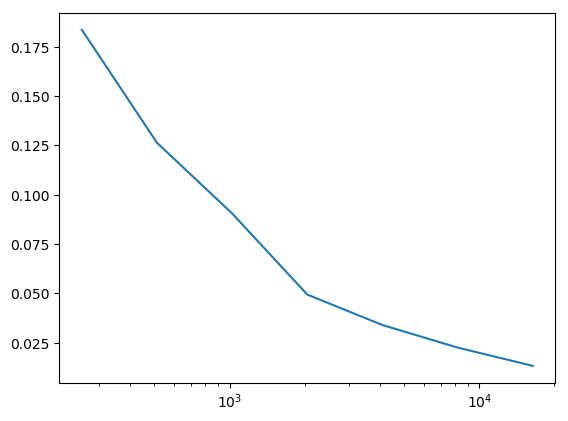

In [15]:
ns = [2^i for i in 8:14]
plot(ns, [mean(giant_component(n, 1/sqrt(n)) for i in 1:16) for n in ns])
plt.xscale("log")